In [6]:
import numpy as np
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from src.utils_CTMC import build_Q, build_R
from src.event_processing import leer_excel, separar_partido_del_equipo_en_lineups, separar_partido_en_equipo_pov, separar_partidos

In [2]:
epl = leer_excel("./Sample Data/epl.xlsx")

In [3]:
partidos = separar_partidos(epl)
equipoA, equipoB = separar_partido_en_equipo_pov(partidos[0])
lineups = separar_partido_del_equipo_en_lineups(equipoA)
Q_matrices = [build_Q(build_R(lineup)) for lineup in lineups]

In [5]:
Q = torch.tensor(Q_matrices[0], requires_grad=True, dtype=torch.float32)

R = Q[:12, 12:]
T = Q[:12, :12]

M = torch.eye(12) - T
M_inv = torch.inverse(M)
psl = torch.matmul(torch.matmul(torch.tensor([[1.] + [0.] * 11]), M_inv), R).matmul(torch.tensor([0., 1.]))

psl.backward(torch.ones_like(psl))

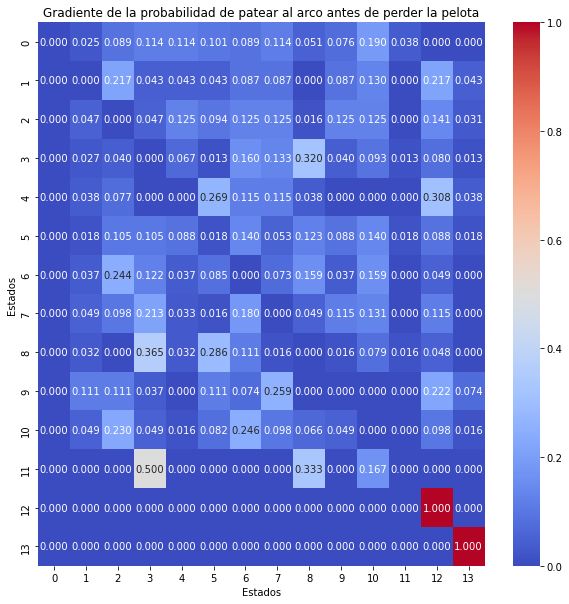

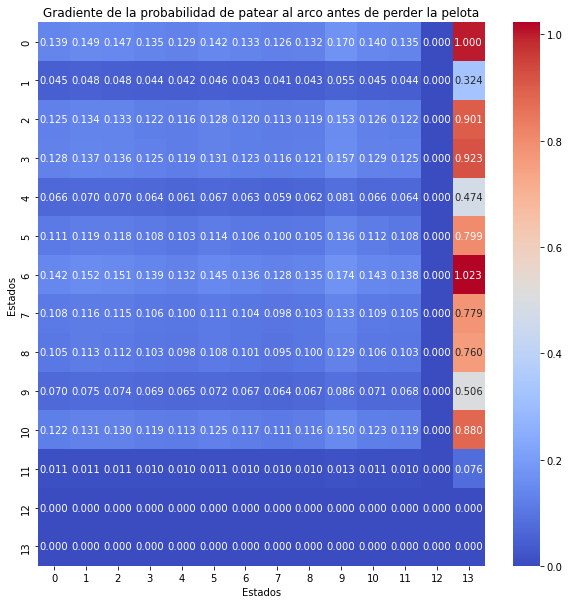

In [7]:
# Gradient Heatmap for PSL
def psl_heatmap(Q, grad=False) -> None:
    """Genera un mapa de calor de la probabilidad de patear al arco antes de perder la pelota
    """

    fig, ax = plt.subplots(figsize=(10, 10))
    if grad:
        sns.heatmap(Q.grad.numpy(), ax=ax, cmap="coolwarm", annot=True, fmt=".3f")
    else:
        sns.heatmap(Q.detach().numpy(), ax=ax, cmap="coolwarm", annot=True, fmt=".3f")

    ax.set_title("Gradiente de la probabilidad de patear al arco antes de perder la pelota")
    ax.set_xlabel("Estados")
    ax.set_ylabel("Estados")

    plt.show()

psl_heatmap(Q)
psl_heatmap(Q, grad=True)

## Optimizamos una fila (jugador) para maximizar PSL

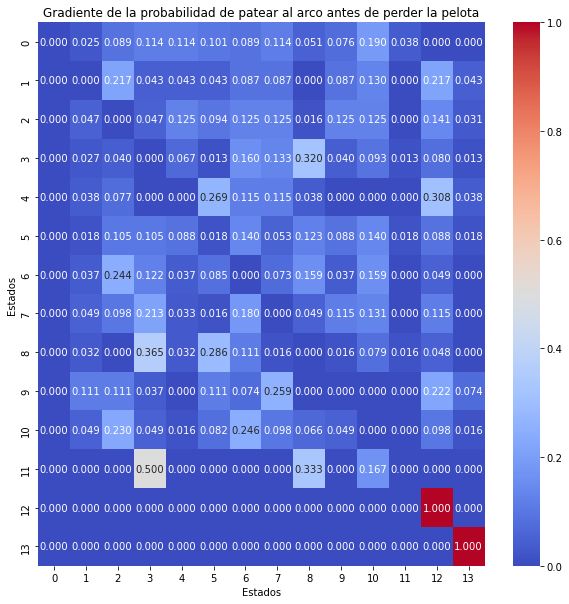

/tmp/ipykernel_119310/3973361472.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q1 = torch.tensor(Q[2, 1:12].clone(), requires_grad=True)


Iteración 100, psl: 0.16610418260097504
Iteración 200, psl: 0.16611237823963165
Iteración 300, psl: 0.166111558675766
Iteración 400, psl: 0.16611109673976898
Iteración 500, psl: 0.1661108434200287
Iteración 600, psl: 0.16611072421073914
Iteración 700, psl: 0.16611060500144958
Iteración 800, psl: 0.16611053049564362
Iteración 900, psl: 0.16611042618751526
Iteración 1000, psl: 0.16611047089099884
psl optimizado: 0.16611047089099884


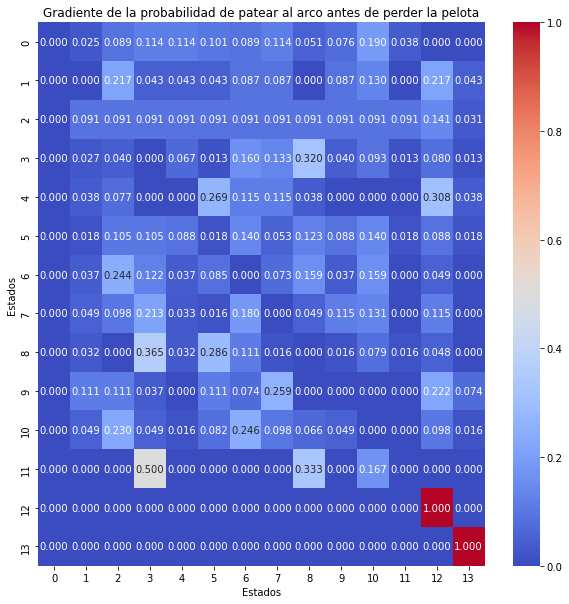

In [25]:
# Creamos una copia de Q para evitar modificar la original
Q = torch.tensor(Q_matrices[0], dtype=torch.float32)

psl_heatmap(Q)

# Definimos Q[1, :] como un tensor independiente con requires_grad=True
Q1 = torch.tensor(Q[2, 1:12].clone(), requires_grad=True)

# Definimos el optimizador para Q1
optimizer = optim.Adam([Q1], lr=0.005)

# Definimos la cantidad de iteraciones para la optimización
num_iterations = 1000

for i in range(num_iterations):
    # Zero grad para limpiar los gradientes acumulados
    optimizer.zero_grad()

    # Actualizamos Q[1, :] con el tensor Q1
    Q[2, 1:12] = Q1

    # Recalculamos R y T con el nuevo Q
    R = Q[:12, 12:]
    T = Q[:12, :12]

    # Calculamos M y M_inv
    M = torch.eye(12) - T
    M_inv = torch.inverse(M)

    # Calculamos psl
    psl = torch.matmul(torch.matmul(torch.tensor([[1.] + [0.] * 11]), M_inv), R).matmul(torch.tensor([0., 1.]))

    # Negamos psl ya que queremos maximizar (los optimizadores minimizan por defecto)
    loss = -psl

    # Backward para calcular los gradientes
    loss.backward(retain_graph=True)

    # Paso del optimizador para actualizar Q1
    optimizer.step()

    with torch.no_grad():
        Q1 /= Q1.sum()

    # Imprimir el valor de psl durante la optimización
    if (i + 1) % 100 == 0:
        print(f"Iteración {i+1}, psl: {-loss.item()}")
    if (-loss.item() > 0.8):
        break

# Resultado final
print(f"psl optimizado: {-loss.item()}")
psl_heatmap(Q)

psl para i=1: 0.14344513416290283


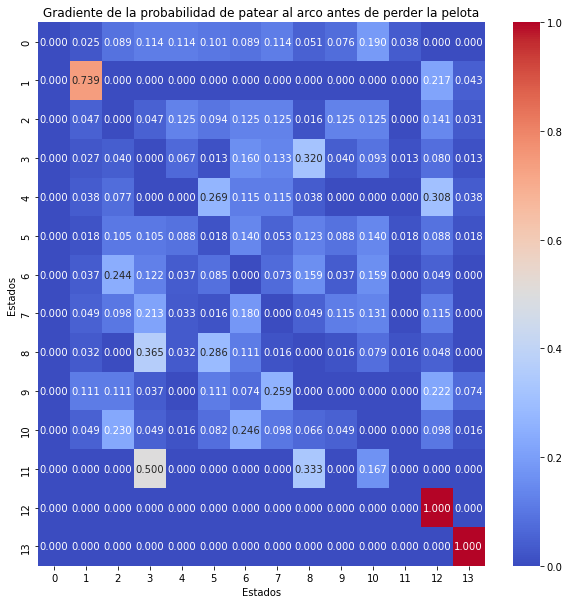

psl para i=2: 0.13982893526554108


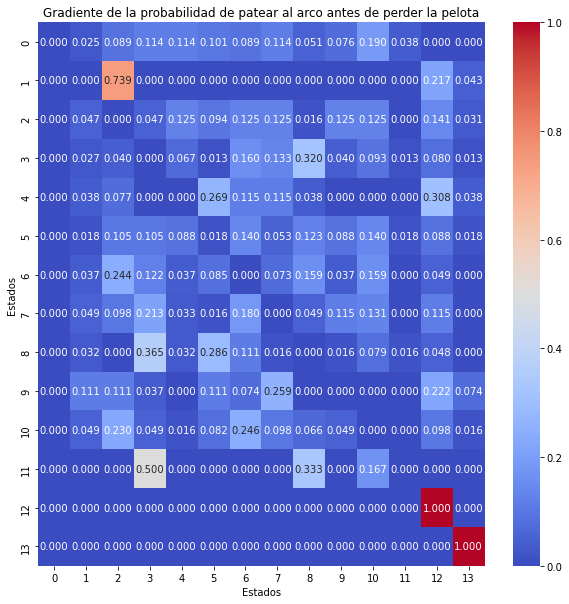

psl para i=3: 0.13704746961593628


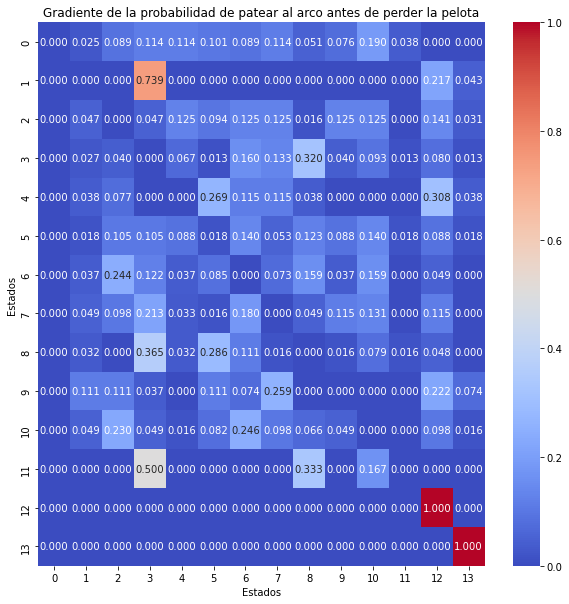

psl para i=4: 0.13557729125022888


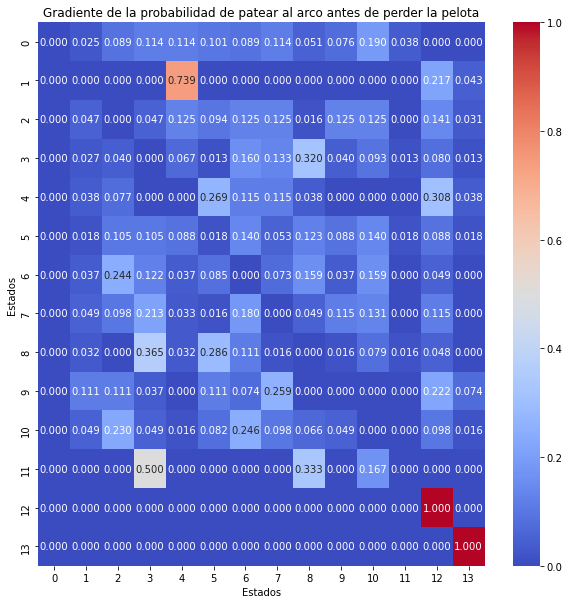

psl para i=5: 0.13862858712673187


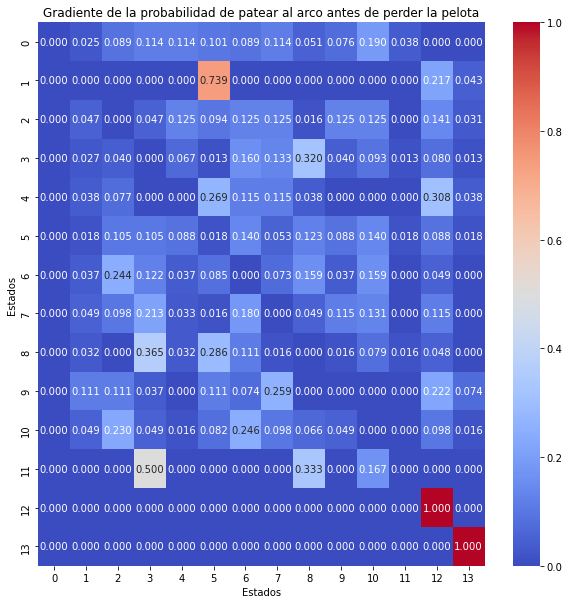

psl para i=6: 0.13646160066127777


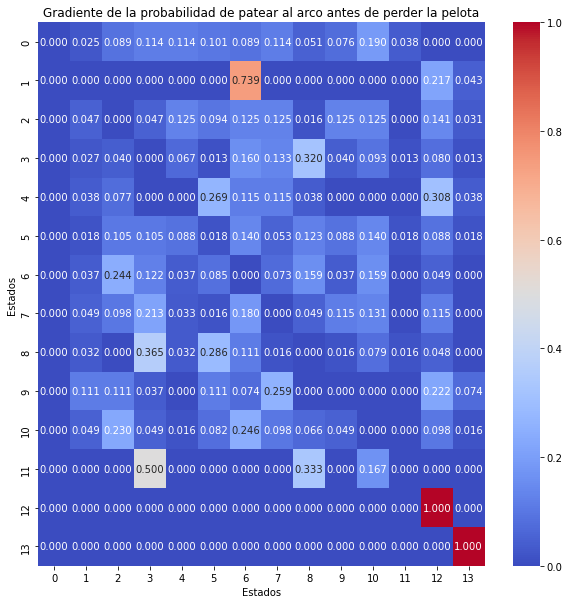

psl para i=7: 0.134633406996727


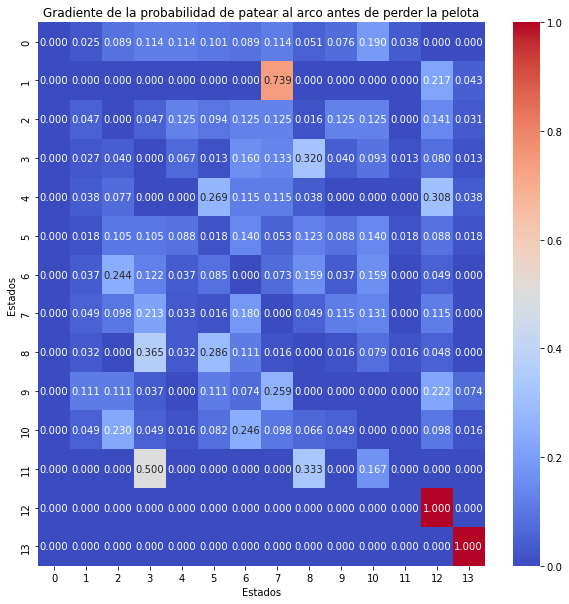

psl para i=8: 0.13609589636325836


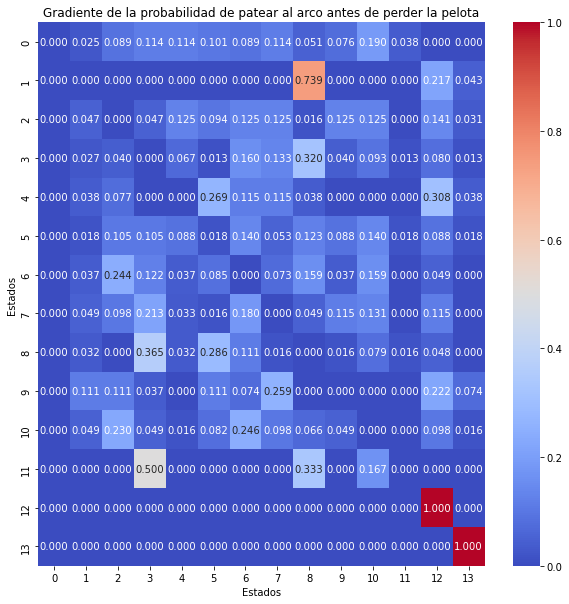

psl para i=9: 0.14542393386363983


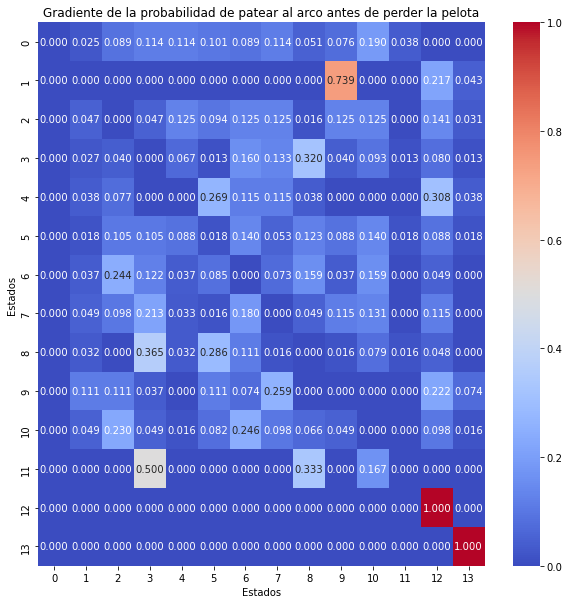

psl para i=10: 0.13812090456485748


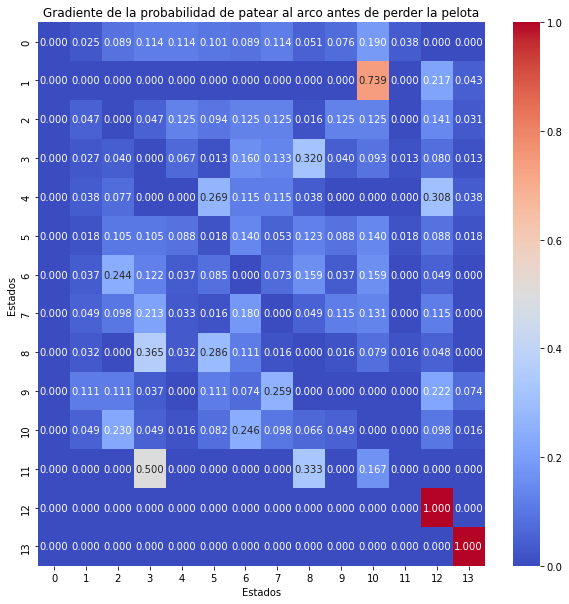

psl para i=11: 0.13690966367721558


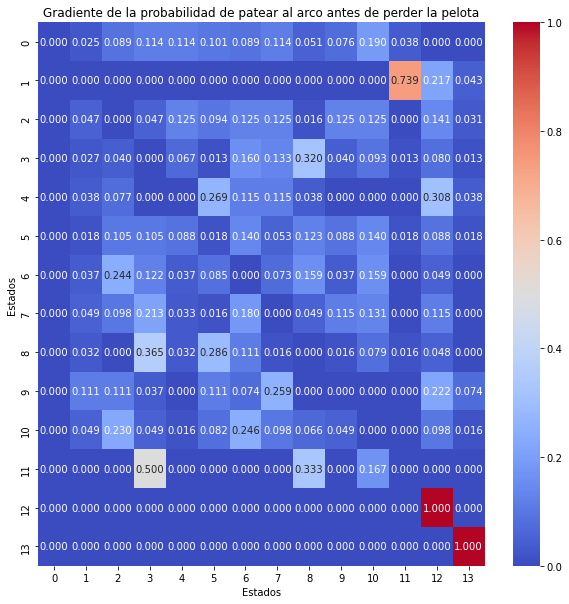

In [34]:
for i in range(1, 12):
    Q = torch.tensor(Q_matrices[0], dtype=torch.float32)
    Q[1, i] = 1 - Q[1,12:].sum()
    Q[1, 0:i] = 0
    Q[1, i+1:12] = 0

    R = Q[:12, 12:]
    T = Q[:12, :12]
    M = torch.eye(12) - T
    M_inv = torch.inverse(M)
    psl = torch.matmul(torch.matmul(torch.tensor([[1.] + [0.] * 11]), M_inv), R).matmul(torch.tensor([0., 1.]))
    print(f"psl para i={i}: {psl.item()}")
    psl_heatmap(Q)